# 1.Import libraries

In [1]:
!pip install gdown

In [2]:
!pip install pylibtiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 2.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pylibtiff: filename=pylibtiff-0.6.1-cp310-cp310-linux_x86_64.whl size=172127 sha256=449352f3398d95b9731cf06c06b1c6ea1315c9825f787cbfd6921dc129503de2
  Stored in directory: /root/.cache/pip/wheels/18/3a/a4/2fecac4e3bf7f84b3cac4d79f138869401b18dde7a3f07e591
Successfully built pylibtiff


In [3]:
import requests
import zipfile
import gdown
import rasterio
from rasterio.plot import show

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation, RandomResizedCrop
import torchvision.transforms as transforms

from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import numpy as np
import cv2
import os

torch.manual_seed(25)

# 2.1.Install data

In [4]:
url = 'https://drive.google.com/file/d/1585dvdRwfFsYKlkdvoJylxxqAQOyQV_G/view?usp=sharing'
output_path = '/kaggle/working/pre_data.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1585dvdRwfFsYKlkdvoJylxxqAQOyQV_G
From (redirected): https://drive.google.com/uc?id=1585dvdRwfFsYKlkdvoJylxxqAQOyQV_G&confirm=t&uuid=c2121e1b-1923-426b-82b5-88e38c2bd34c
To: /kaggle/working/pre_data.zip
100%|██████████| 68.7M/68.7M [00:00<00:00, 102MB/s] 


'/kaggle/working/pre_data.zip'

In [5]:
extract_dir = '/kaggle/working/'

with zipfile.ZipFile('/kaggle/working/pre_data.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [6]:
import rasterio
from rasterio.plot import show

path = '/kaggle/working/data/images/1.tif'

with rasterio.open(path) as image:
    image_array = image.read()

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
dataset = [[], []]
for i in range(0, 306):
    img_path = f'/kaggle/working/data/images/{i}.tif'
    label_path = f'/kaggle/working/data/labels/{i}.png'
    with rasterio.open(img_path) as image:
        image_array = image.read()
    with rasterio.open(label_path) as image:
        label_array = image.read()
    normalized_image_array = []
    for j in range(12):
        normalized_band = image_array[j]/image_array[j].max() if image_array[j].max()!=0 else image_array[j]/1
        normalized_image_array.append(normalized_band)
    normalized_image_array = np.array(normalized_image_array)
    label_array = np.array(label_array)
    dataset[0].append(normalized_image_array)
    dataset[1].append(label_array)

# 2.2.Visualize data

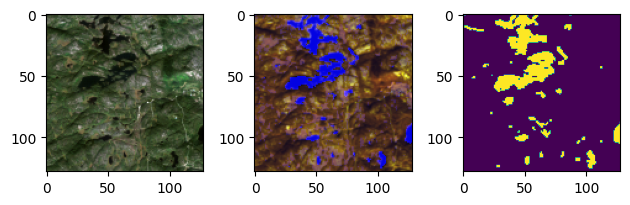

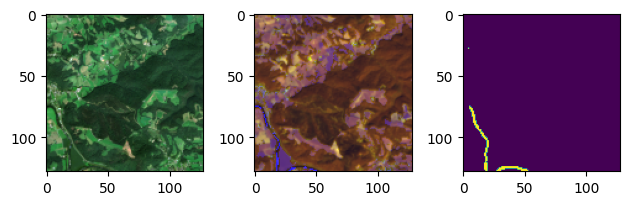

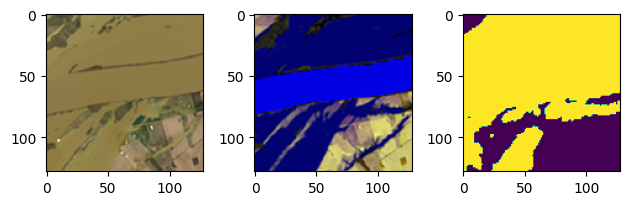

In [8]:
for i in range(3):
    x, y = dataset[0], dataset[1][i]
    x = x[i].transpose((1, 2, 0))
    y = y.transpose((1, 2, 0))
    x, z = x[:, :, [3, 2, 1]], x[:, :, [5, 6, 10]] # RGB - (SWIR1, SWIR2, ESA)
    fig, axes = plt.subplots(nrows=1, ncols=3)
    axes[0].imshow(x)
    axes[1].imshow(z)
    axes[2].imshow(y)
    plt.tight_layout()
    plt.show()

In [9]:
img_dataset = np.array(dataset[0])
label_dataset = np.array(dataset[1])

# 2.3.Prepare data

In [10]:
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        label = torch.from_numpy(self.labels[idx]).float()
        return image, label

In [11]:
torch_dataset = MyDataset(img_dataset[:255], label_dataset[:255])
val_torch_dataset = MyDataset(img_dataset[255:], label_dataset[255:])

In [51]:
batch_size = 32
train_loader = DataLoader(torch_dataset, batch_size=batch_size)
valid_loader = DataLoader(val_torch_dataset, batch_size=batch_size)

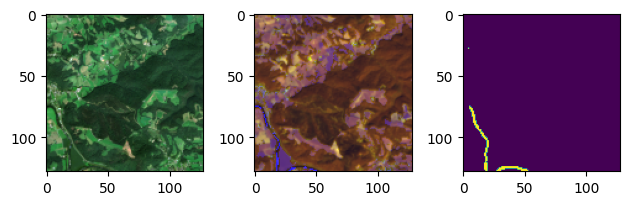

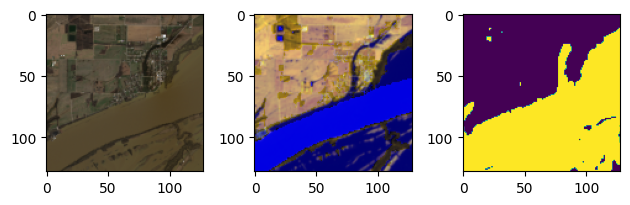

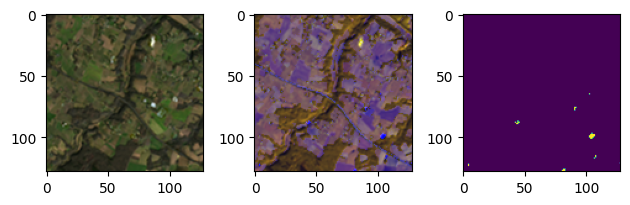

In [13]:
timer = 3
for x, y in train_loader:
    x = x.permute((0, 2, 3, 1))
    y = y.permute((0, 2, 3, 1))
    x, z = x[1, :, :, [3, 2, 1]], x[1, :, :, [5, 6, 10]] # RGB - (SWIR1, SWIR2, ESA)
    fig, axes = plt.subplots(nrows=1, ncols=3)
    axes[0].imshow(x)
    axes[1].imshow(z)
    axes[2].imshow(y[1])
    plt.tight_layout()
    plt.show()
    timer-=1
    if timer == 0:
        break

# 3.1.Model creation

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
import torchvision.models as models
import torch.nn.functional as F
from torchinfo import summary

In [16]:
class SimplifiedUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(SimplifiedUNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)

        self.upconv1 = nn.ConvTranspose2d(256, 256, 1, stride=1)
        self.conv3 = nn.Conv2d(256 + 256, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.final_conv = nn.Conv2d(256, out_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = nn.ReLU()(x1)
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = nn.ReLU()(x2)

        x = self.upconv1(x2)
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)

        x = self.final_conv(x)
        x = nn.ReLU()(x)
        x = self.sigmoid(x)
        return x

In [52]:
model = SimplifiedUNet()

In [18]:
summary(model)

Layer (type:depth-idx)                   Param #
SimplifiedUNet                           --
├─Conv2d: 1-1                            27,904
├─BatchNorm2d: 1-2                       512
├─Conv2d: 1-3                            590,080
├─BatchNorm2d: 1-4                       512
├─ConvTranspose2d: 1-5                   65,792
├─Conv2d: 1-6                            1,179,904
├─BatchNorm2d: 1-7                       512
├─Conv2d: 1-8                            257
├─Sigmoid: 1-9                           --
Total params: 1,865,473
Trainable params: 1,865,473
Non-trainable params: 0

In [53]:
model = model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1])

In [54]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 3.2.Model training

In [21]:
def calculate_iou(pred, label):
    pred = pred.long()
    label = label.long()
    intersection = (pred & label).sum().float()
    union = (pred | label).sum().float()
    iou = (intersection + 1e-6) / (union + 1e-6)
    return float(iou)

In [22]:
def train(model, optimizer, criterion, train_generator, validation_generator, epochs, device, history = [[[], []],[[], []]]):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f'--- Epoch {epoch+1} ---')

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train_images = 0

        with tqdm(total=len(train_generator)) as pbar:
            for images, labels in train_generator:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                predicted = (outputs > 0.5).float()

                running_loss += loss.item()
                running_corrects  += calculate_iou(predicted, labels)
                total_train_images += labels.size(0)

                pbar.update(1)

        epoch_train_loss = running_loss / total_train_images
        epoch_train_acc = 100 * batch_size * running_corrects / total_train_images

        history[0][0].append(epoch_train_loss)
        history[0][1].append(epoch_train_acc)
        
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_val_images = 0
        
        with torch.no_grad():
            for images, labels in validation_generator:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                predicted = (outputs > 0.5).float()
                running_loss += loss.item()
                running_corrects += calculate_iou(predicted, labels)
                total_val_images += labels.size(0)

            epoch_val_loss = running_loss / total_val_images
            epoch_val_acc = 100 * batch_size * running_corrects / total_val_images
            
            history[1][0].append(epoch_val_loss)
            history[1][1].append(epoch_val_acc)
            
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}% --- Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}%')
            
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_wts)
    return model, history

In [55]:
history = [[[], []],[[], []]]

In [56]:
model, history = train(model, optimizer, criterion, train_loader, valid_loader, 100, device, history)

--- Epoch 1 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0208, Train Accuracy: 46.7558% --- Val Loss: 0.0270, Val Accuracy: 56.9714%
--- Epoch 2 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0195, Train Accuracy: 58.3340% --- Val Loss: 0.0268, Val Accuracy: 57.6835%
--- Epoch 3 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0193, Train Accuracy: 59.3650% --- Val Loss: 0.0266, Val Accuracy: 62.1806%
--- Epoch 4 ---


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Train Loss: 0.0192, Train Accuracy: 60.1982% --- Val Loss: 0.0263, Val Accuracy: 70.3441%
--- Epoch 5 ---


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


Train Loss: 0.0192, Train Accuracy: 61.3181% --- Val Loss: 0.0260, Val Accuracy: 75.6766%
--- Epoch 6 ---


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]


Train Loss: 0.0191, Train Accuracy: 62.4125% --- Val Loss: 0.0258, Val Accuracy: 77.2988%
--- Epoch 7 ---


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Train Loss: 0.0191, Train Accuracy: 63.1567% --- Val Loss: 0.0256, Val Accuracy: 78.1186%
--- Epoch 8 ---


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Train Loss: 0.0191, Train Accuracy: 63.6607% --- Val Loss: 0.0255, Val Accuracy: 78.6543%
--- Epoch 9 ---


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Train Loss: 0.0191, Train Accuracy: 63.8595% --- Val Loss: 0.0254, Val Accuracy: 79.0596%
--- Epoch 10 ---


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Train Loss: 0.0190, Train Accuracy: 63.9850% --- Val Loss: 0.0253, Val Accuracy: 79.3667%
--- Epoch 11 ---


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]


Train Loss: 0.0190, Train Accuracy: 64.0612% --- Val Loss: 0.0253, Val Accuracy: 79.6381%
--- Epoch 12 ---


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


Train Loss: 0.0190, Train Accuracy: 64.0360% --- Val Loss: 0.0252, Val Accuracy: 79.7577%
--- Epoch 13 ---


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]


Train Loss: 0.0190, Train Accuracy: 64.1689% --- Val Loss: 0.0252, Val Accuracy: 79.8068%
--- Epoch 14 ---


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Train Loss: 0.0189, Train Accuracy: 64.1803% --- Val Loss: 0.0251, Val Accuracy: 79.9512%
--- Epoch 15 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0189, Train Accuracy: 64.3109% --- Val Loss: 0.0251, Val Accuracy: 79.9394%
--- Epoch 16 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0189, Train Accuracy: 64.3291% --- Val Loss: 0.0251, Val Accuracy: 80.0934%
--- Epoch 17 ---


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Train Loss: 0.0189, Train Accuracy: 64.3830% --- Val Loss: 0.0250, Val Accuracy: 80.1192%
--- Epoch 18 ---


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Train Loss: 0.0189, Train Accuracy: 64.3525% --- Val Loss: 0.0250, Val Accuracy: 80.2370%
--- Epoch 19 ---


100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


Train Loss: 0.0189, Train Accuracy: 64.4732% --- Val Loss: 0.0250, Val Accuracy: 80.2262%
--- Epoch 20 ---


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Train Loss: 0.0189, Train Accuracy: 64.4768% --- Val Loss: 0.0249, Val Accuracy: 80.3719%
--- Epoch 21 ---


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Train Loss: 0.0188, Train Accuracy: 64.5517% --- Val Loss: 0.0249, Val Accuracy: 80.2818%
--- Epoch 22 ---


100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Train Loss: 0.0188, Train Accuracy: 64.6609% --- Val Loss: 0.0249, Val Accuracy: 80.2312%
--- Epoch 23 ---


100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Train Loss: 0.0188, Train Accuracy: 64.5580% --- Val Loss: 0.0249, Val Accuracy: 80.3475%
--- Epoch 24 ---


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Train Loss: 0.0188, Train Accuracy: 64.8169% --- Val Loss: 0.0249, Val Accuracy: 80.2550%
--- Epoch 25 ---


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Train Loss: 0.0188, Train Accuracy: 64.7121% --- Val Loss: 0.0248, Val Accuracy: 80.4248%
--- Epoch 26 ---


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Train Loss: 0.0188, Train Accuracy: 64.9209% --- Val Loss: 0.0248, Val Accuracy: 80.3090%
--- Epoch 27 ---


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Train Loss: 0.0188, Train Accuracy: 64.5752% --- Val Loss: 0.0248, Val Accuracy: 80.6933%
--- Epoch 28 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0188, Train Accuracy: 65.0014% --- Val Loss: 0.0248, Val Accuracy: 80.5225%
--- Epoch 29 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0188, Train Accuracy: 64.8090% --- Val Loss: 0.0248, Val Accuracy: 80.8229%
--- Epoch 30 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0188, Train Accuracy: 65.0689% --- Val Loss: 0.0248, Val Accuracy: 80.4872%
--- Epoch 31 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0188, Train Accuracy: 64.7025% --- Val Loss: 0.0247, Val Accuracy: 81.0219%
--- Epoch 32 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0187, Train Accuracy: 65.1538% --- Val Loss: 0.0247, Val Accuracy: 80.7184%
--- Epoch 33 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0187, Train Accuracy: 65.0421% --- Val Loss: 0.0247, Val Accuracy: 80.9838%
--- Epoch 34 ---


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Train Loss: 0.0187, Train Accuracy: 65.2923% --- Val Loss: 0.0247, Val Accuracy: 80.7924%
--- Epoch 35 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0187, Train Accuracy: 65.1440% --- Val Loss: 0.0246, Val Accuracy: 81.2142%
--- Epoch 36 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0187, Train Accuracy: 65.3863% --- Val Loss: 0.0247, Val Accuracy: 80.8454%
--- Epoch 37 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0187, Train Accuracy: 65.0247% --- Val Loss: 0.0246, Val Accuracy: 81.4559%
--- Epoch 38 ---


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Train Loss: 0.0187, Train Accuracy: 65.4424% --- Val Loss: 0.0246, Val Accuracy: 81.1656%
--- Epoch 39 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0187, Train Accuracy: 65.1524% --- Val Loss: 0.0246, Val Accuracy: 81.5125%
--- Epoch 40 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0187, Train Accuracy: 65.5315% --- Val Loss: 0.0246, Val Accuracy: 81.2477%
--- Epoch 41 ---


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Train Loss: 0.0187, Train Accuracy: 65.3942% --- Val Loss: 0.0246, Val Accuracy: 81.4832%
--- Epoch 42 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0187, Train Accuracy: 65.6199% --- Val Loss: 0.0246, Val Accuracy: 81.2692%
--- Epoch 43 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0187, Train Accuracy: 65.4702% --- Val Loss: 0.0246, Val Accuracy: 81.5396%
--- Epoch 44 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0187, Train Accuracy: 65.6967% --- Val Loss: 0.0246, Val Accuracy: 81.2949%
--- Epoch 45 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0187, Train Accuracy: 65.5471% --- Val Loss: 0.0245, Val Accuracy: 81.6510%
--- Epoch 46 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0186, Train Accuracy: 65.7865% --- Val Loss: 0.0246, Val Accuracy: 81.3685%
--- Epoch 47 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0186, Train Accuracy: 65.6327% --- Val Loss: 0.0245, Val Accuracy: 81.7414%
--- Epoch 48 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0186, Train Accuracy: 65.8603% --- Val Loss: 0.0245, Val Accuracy: 81.4237%
--- Epoch 49 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0186, Train Accuracy: 65.7421% --- Val Loss: 0.0245, Val Accuracy: 81.7473%
--- Epoch 50 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0186, Train Accuracy: 65.9517% --- Val Loss: 0.0245, Val Accuracy: 81.5135%
--- Epoch 51 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0186, Train Accuracy: 65.8414% --- Val Loss: 0.0245, Val Accuracy: 81.8139%
--- Epoch 52 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0186, Train Accuracy: 66.0289% --- Val Loss: 0.0245, Val Accuracy: 81.6516%
--- Epoch 53 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0186, Train Accuracy: 65.9047% --- Val Loss: 0.0245, Val Accuracy: 81.9372%
--- Epoch 54 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0186, Train Accuracy: 66.1058% --- Val Loss: 0.0245, Val Accuracy: 81.6579%
--- Epoch 55 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0186, Train Accuracy: 65.9589% --- Val Loss: 0.0245, Val Accuracy: 81.9384%
--- Epoch 56 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0186, Train Accuracy: 66.1879% --- Val Loss: 0.0245, Val Accuracy: 81.7351%
--- Epoch 57 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0186, Train Accuracy: 66.0238% --- Val Loss: 0.0245, Val Accuracy: 81.9750%
--- Epoch 58 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0186, Train Accuracy: 66.2494% --- Val Loss: 0.0245, Val Accuracy: 81.8050%
--- Epoch 59 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0186, Train Accuracy: 66.0918% --- Val Loss: 0.0244, Val Accuracy: 82.1503%
--- Epoch 60 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0186, Train Accuracy: 66.3183% --- Val Loss: 0.0245, Val Accuracy: 81.8391%
--- Epoch 61 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0186, Train Accuracy: 66.1488% --- Val Loss: 0.0244, Val Accuracy: 82.1302%
--- Epoch 62 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0186, Train Accuracy: 66.3874% --- Val Loss: 0.0245, Val Accuracy: 81.8756%
--- Epoch 63 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0186, Train Accuracy: 66.2116% --- Val Loss: 0.0244, Val Accuracy: 82.1567%
--- Epoch 64 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0186, Train Accuracy: 66.4464% --- Val Loss: 0.0244, Val Accuracy: 81.9482%
--- Epoch 65 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0186, Train Accuracy: 66.2314% --- Val Loss: 0.0244, Val Accuracy: 82.2170%
--- Epoch 66 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0186, Train Accuracy: 66.4965% --- Val Loss: 0.0244, Val Accuracy: 81.9148%
--- Epoch 67 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0186, Train Accuracy: 66.2891% --- Val Loss: 0.0244, Val Accuracy: 82.2030%
--- Epoch 68 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0186, Train Accuracy: 66.5585% --- Val Loss: 0.0244, Val Accuracy: 81.9569%
--- Epoch 69 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.3933% --- Val Loss: 0.0244, Val Accuracy: 82.1999%
--- Epoch 70 ---


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Train Loss: 0.0185, Train Accuracy: 66.6140% --- Val Loss: 0.0244, Val Accuracy: 81.9761%
--- Epoch 71 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.4445% --- Val Loss: 0.0244, Val Accuracy: 82.2257%
--- Epoch 72 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.6681% --- Val Loss: 0.0244, Val Accuracy: 82.0722%
--- Epoch 73 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0185, Train Accuracy: 66.5194% --- Val Loss: 0.0244, Val Accuracy: 82.2344%
--- Epoch 74 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 66.7207% --- Val Loss: 0.0244, Val Accuracy: 82.1619%
--- Epoch 75 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.4866% --- Val Loss: 0.0244, Val Accuracy: 82.3011%
--- Epoch 76 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0185, Train Accuracy: 66.7807% --- Val Loss: 0.0244, Val Accuracy: 82.0843%
--- Epoch 77 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0185, Train Accuracy: 66.5476% --- Val Loss: 0.0244, Val Accuracy: 82.2483%
--- Epoch 78 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0185, Train Accuracy: 66.8259% --- Val Loss: 0.0244, Val Accuracy: 82.0931%
--- Epoch 79 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 66.6784% --- Val Loss: 0.0244, Val Accuracy: 82.2623%
--- Epoch 80 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 66.8762% --- Val Loss: 0.0244, Val Accuracy: 82.1031%
--- Epoch 81 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.7147% --- Val Loss: 0.0244, Val Accuracy: 82.2581%
--- Epoch 82 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 66.9276% --- Val Loss: 0.0244, Val Accuracy: 82.1597%
--- Epoch 83 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.7068% --- Val Loss: 0.0244, Val Accuracy: 82.2917%
--- Epoch 84 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.9741% --- Val Loss: 0.0244, Val Accuracy: 82.0825%
--- Epoch 85 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0185, Train Accuracy: 66.7615% --- Val Loss: 0.0244, Val Accuracy: 82.2394%
--- Epoch 86 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 67.0197% --- Val Loss: 0.0244, Val Accuracy: 82.1173%
--- Epoch 87 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 66.8678% --- Val Loss: 0.0244, Val Accuracy: 82.2501%
--- Epoch 88 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 67.0676% --- Val Loss: 0.0244, Val Accuracy: 82.1323%
--- Epoch 89 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0185, Train Accuracy: 66.9296% --- Val Loss: 0.0244, Val Accuracy: 82.2302%
--- Epoch 90 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 67.1120% --- Val Loss: 0.0244, Val Accuracy: 82.1921%
--- Epoch 91 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 66.9251% --- Val Loss: 0.0244, Val Accuracy: 82.3642%
--- Epoch 92 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0185, Train Accuracy: 67.1612% --- Val Loss: 0.0244, Val Accuracy: 82.1408%
--- Epoch 93 ---


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Train Loss: 0.0185, Train Accuracy: 66.9603% --- Val Loss: 0.0244, Val Accuracy: 82.3015%
--- Epoch 94 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 67.2087% --- Val Loss: 0.0244, Val Accuracy: 82.1822%
--- Epoch 95 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 66.9975% --- Val Loss: 0.0244, Val Accuracy: 82.2978%
--- Epoch 96 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 67.2428% --- Val Loss: 0.0244, Val Accuracy: 82.1137%
--- Epoch 97 ---


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Train Loss: 0.0185, Train Accuracy: 67.0694% --- Val Loss: 0.0244, Val Accuracy: 82.2770%
--- Epoch 98 ---


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Train Loss: 0.0185, Train Accuracy: 67.2889% --- Val Loss: 0.0244, Val Accuracy: 82.1507%
--- Epoch 99 ---


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Train Loss: 0.0185, Train Accuracy: 67.1670% --- Val Loss: 0.0244, Val Accuracy: 82.2737%
--- Epoch 100 ---


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Train Loss: 0.0185, Train Accuracy: 67.3371% --- Val Loss: 0.0244, Val Accuracy: 82.2118%


# 3.3.Model evaluation

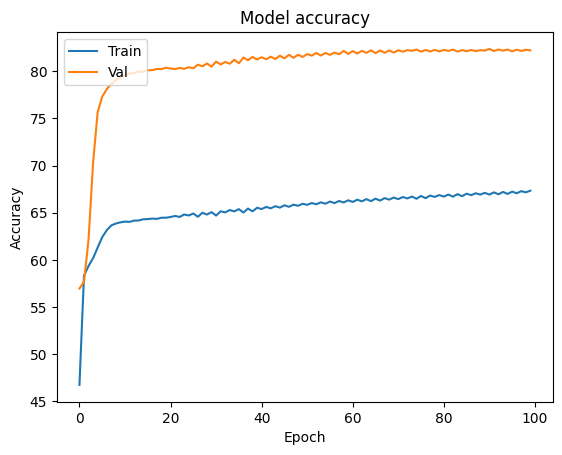

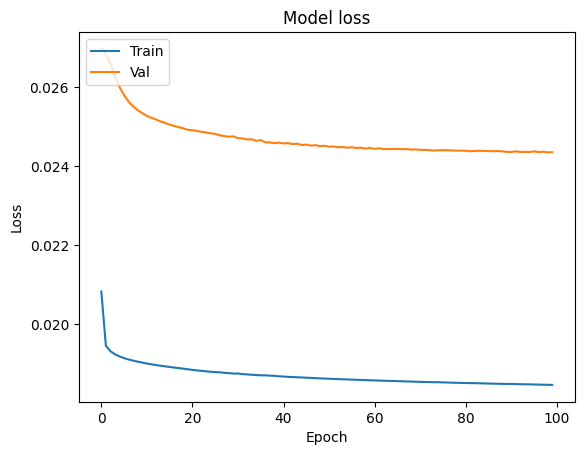

In [57]:
plt.plot(history[0][1])
plt.plot(history[1][1])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.show()

plt.plot(history[0][0])
plt.plot(history[1][0])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

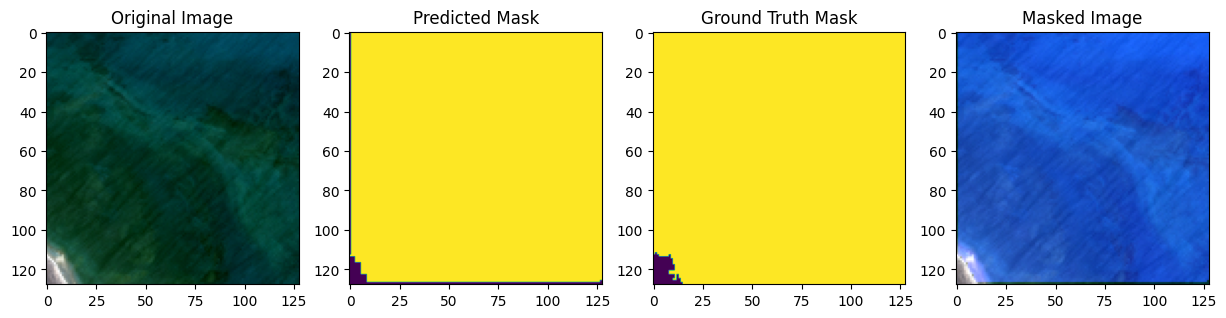

accuracy = 98.22568893%


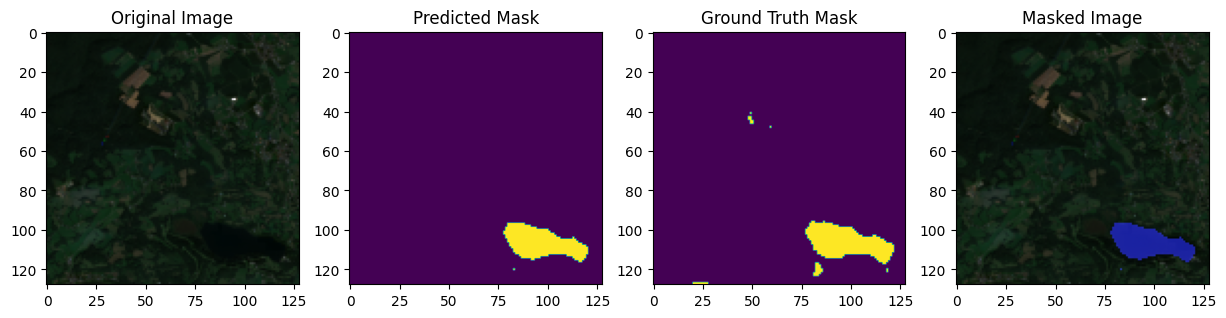

accuracy = 82.06785321%


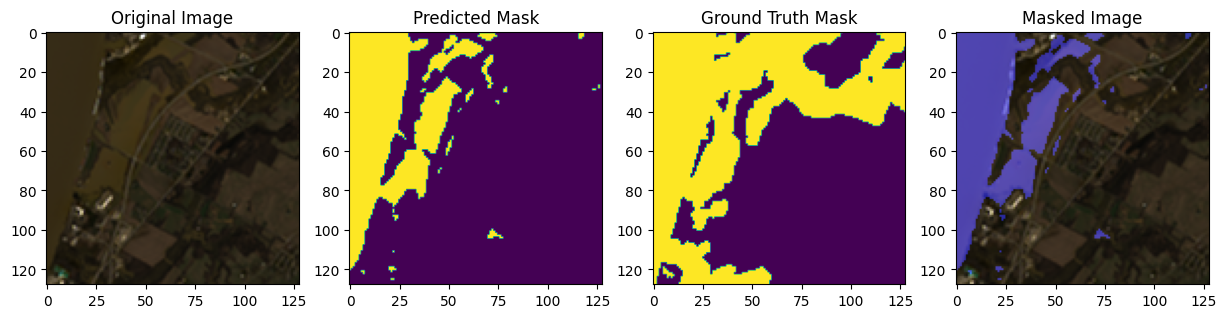

accuracy = 46.00895643%


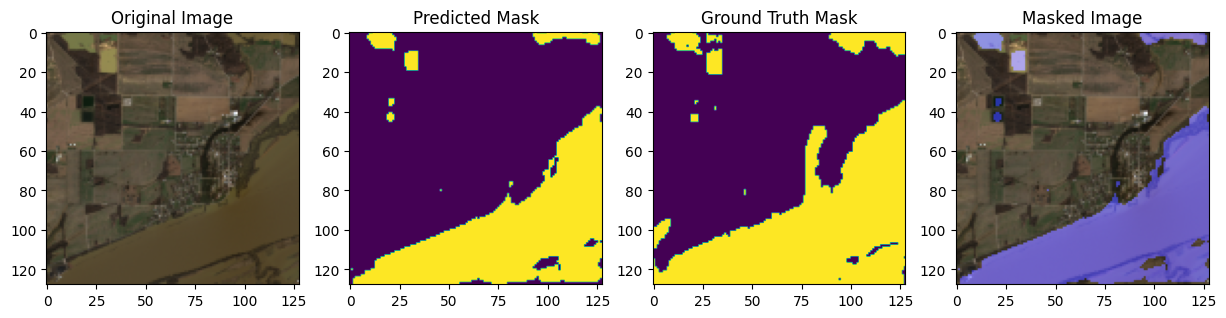

accuracy = 78.96968722%


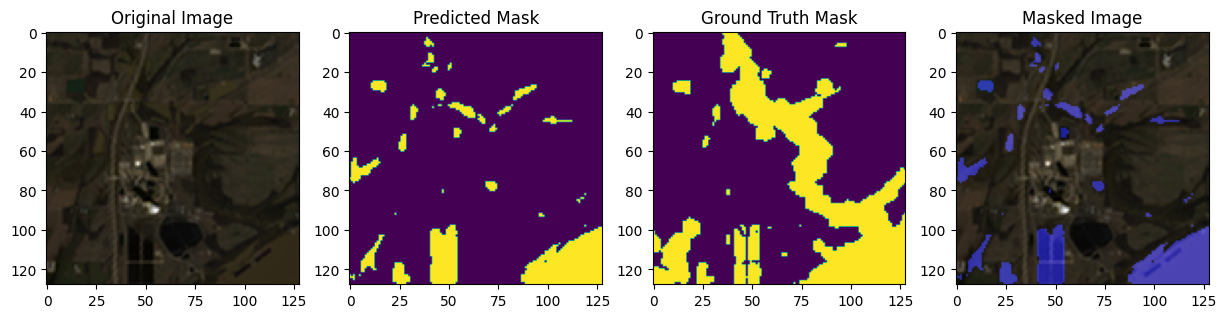

accuracy = 32.86042213%


In [120]:
timer = 5
with torch.no_grad():
    for i in range(timer):
        img_id = np.random.randint(batch_size)
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            running_corrects = calculate_iou(predicted[img_id], labels[img_id])

            images, labels = images.to('cpu'), labels.to('cpu')
            predicted = predicted.to('cpu')

            fig, axes = plt.subplots(1, 4, figsize=(15, 5))

            images = images[img_id].permute((1, 2, 0))
            predicted = predicted[img_id].permute((1, 2, 0)).squeeze(0)
            labels = labels[img_id].permute((1, 2, 0))

            axes[0].imshow(images[:, :, [3, 2, 1]])
            axes[0].set_title('Original Image')

            axes[1].imshow(predicted.squeeze(0))
            axes[1].set_title('Predicted Mask')

            axes[2].imshow(labels.squeeze(0))
            axes[2].set_title('Ground Truth Mask')

            masked_pic = images[:, :, [3, 2, 1]] + np.dstack([predicted*0.1, predicted*0.1, predicted*0.6])
            axes[3].imshow(masked_pic)
            axes[3].set_title('Masked Image')

            plt.show()
            print(f'accuracy = {running_corrects*100:.8f}%')

            break